In [44]:
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm # for oceanography-specific colormaps

In [45]:
ds_temp = xr.open_dataset('../../NHCS/OSTIA/METOFFICE-GLO-SST-L4-REP-OBS-SST_analysed_sst_114.97W-70.03W_15.98S-5.03S_1990-01-01-2010-12-31.nc',
                            chunks = {'time':1})
ds_temp

<xarray.Dataset> Size: 12GB
Dimensions:       (time: 7670, latitude: 220, longitude: 900)
Coordinates:
  * latitude      (latitude) float32 880B -15.98 -15.93 -15.88 ... -5.075 -5.025
  * longitude     (longitude) float32 4kB -115.0 -114.9 -114.9 ... -70.07 -70.03
  * time          (time) datetime64[ns] 61kB 1990-01-01 ... 2010-12-31
Data variables:
    analysed_sst  (time, latitude, longitude) float64 12GB dask.array<chunksize=(1, 220, 900), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                CF-1.4, ACDD-1.3
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    WARNING Some applications are unable to prope...
    creator_email:              servicedesk.cmems@mercator-ocean.eu
    ...                         ...
    time_coverage_end:          19811002T000000Z
    time_coverage_start:        19811001T000000Z
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    uuid:                       a2df4a18-6f19-4772-9532-39307a0e2794
    westernmost_longitude:      -180.0
    copernicusmarine_version:   1.3.5

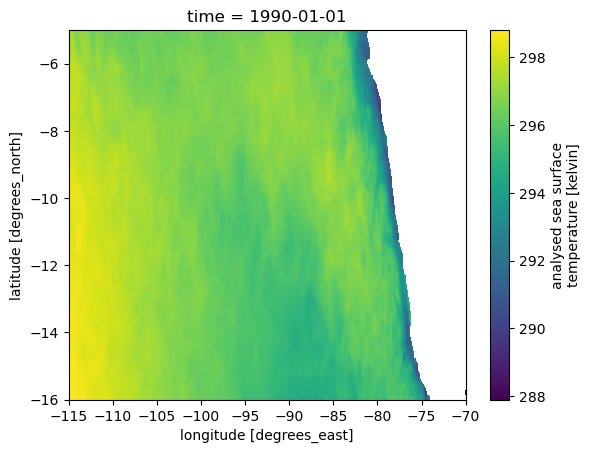

In [46]:
ds_temp.analysed_sst.isel(time=slice(0,1)).plot()

In [47]:
sst = ds_temp.analysed_sst - 273.15

# climatology
clim = sst.groupby("time.month").mean(dim="time")
#monthly average
mm_sst = sst.resample(time="M").mean()
mm_sst

/opt/conda/lib/python3.11/site-packages/xarray/groupers.py:403: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


<xarray.DataArray 'analysed_sst' (time: 252, latitude: 220, longitude: 900)> Size: 399MB
dask.array<stack, shape=(252, 220, 900), dtype=float64, chunksize=(1, 220, 900), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 880B -15.98 -15.93 -15.88 ... -5.075 -5.025
  * longitude  (longitude) float32 4kB -115.0 -114.9 -114.9 ... -70.07 -70.03
  * time       (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31

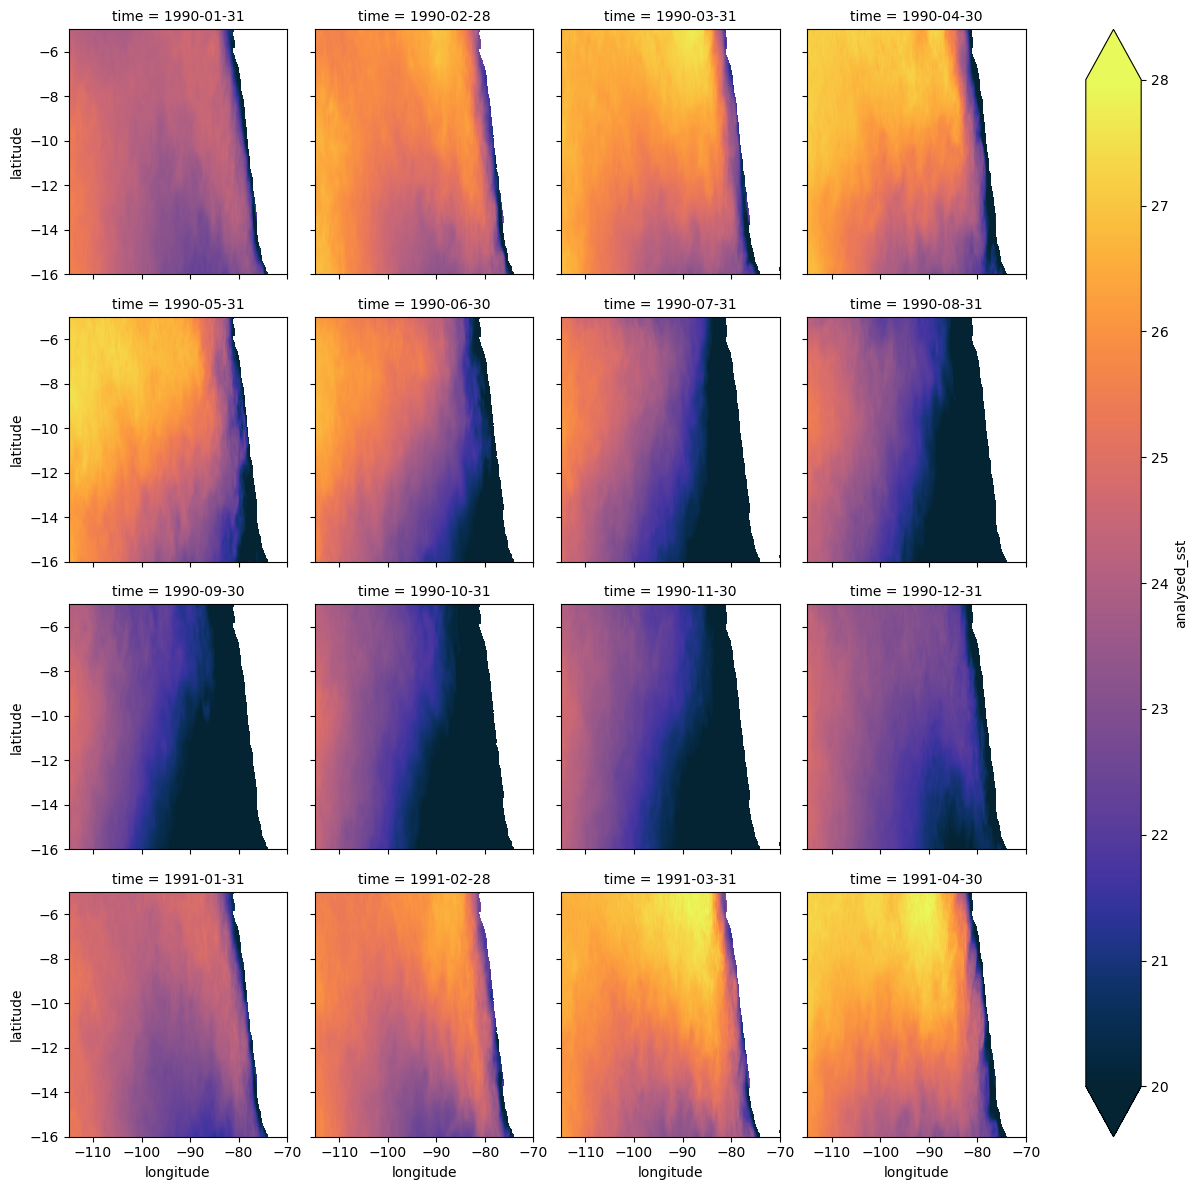

In [48]:
mm_sst.isel(time=slice(None,16)).plot(x="longitude", y="latitude", cmap=cm.thermal, col='time',col_wrap=4,
                                   vmin =20, vmax=28)

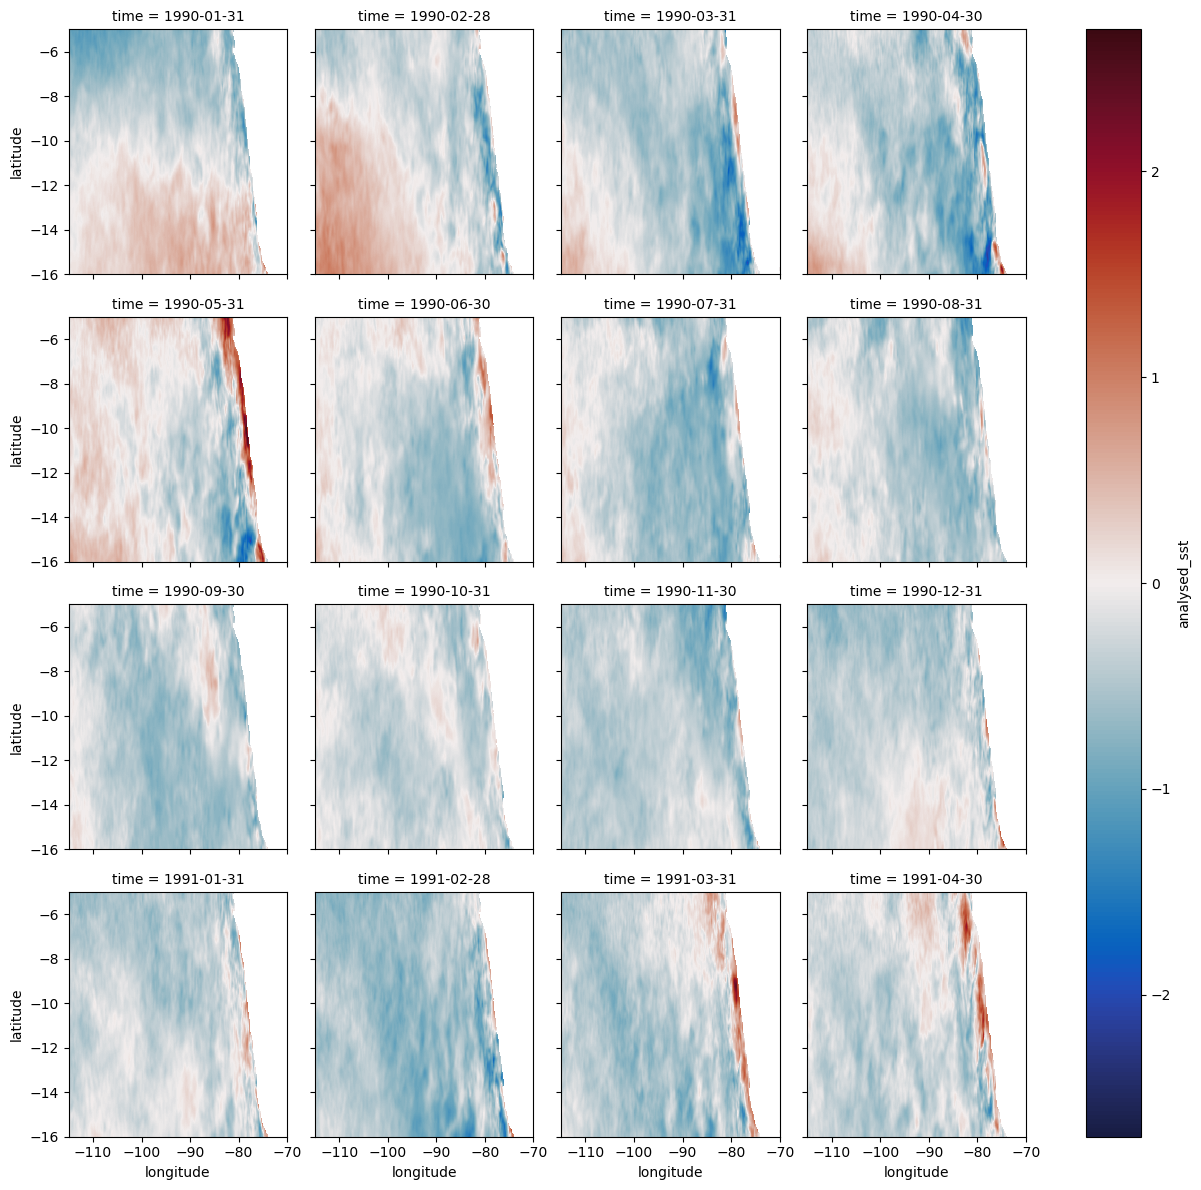

In [49]:
## monthly anomaly 
monthly_anomaly = mm_sst.groupby("time.month") - clim

monthly_anomaly.isel(time=slice(None,16)).plot(x="longitude", y="latitude", cmap=cm.balance,
                                              col = 'time', col_wrap=4)

In [50]:
### create a DataSet
SST = xr.Dataset(
    data_vars = {
        'SST':mm_sst,
        'SSTa':monthly_anomaly
    }
)
SST

<xarray.Dataset> Size: 798MB
Dimensions:    (latitude: 220, longitude: 900, time: 252)
Coordinates:
  * latitude   (latitude) float32 880B -15.98 -15.93 -15.88 ... -5.075 -5.025
  * longitude  (longitude) float32 4kB -115.0 -114.9 -114.9 ... -70.07 -70.03
  * time       (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31
    month      (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    SST        (time, latitude, longitude) float64 399MB dask.array<chunksize=(1, 220, 900), meta=np.ndarray>
    SSTa       (time, latitude, longitude) float64 399MB dask.array<chunksize=(1, 220, 900), meta=np.ndarray>

## Old CUI

In [51]:
## kml to struct
import re
from xml.etree import ElementTree as ET
import numpy as np

def kml2struct(kml_file):
    """
    Import a .kml file as a list of dictionary structures with fields:
    Geometry, Name, Description, Lon, Lat, and BoundingBox.
    """
    # Read the KML file
    try:
        with open(kml_file, 'r', encoding='utf-8') as file:
            txt = file.read()
    except Exception as e:
        raise FileNotFoundError(f"Unable to open file {kml_file}: {e}")

    # Regular expression to match Placemark tags
    expr = r"<Placemark.+?>.+?</Placemark>"
    object_strings = re.findall(expr, txt, re.DOTALL)
    
    kml_struct = []

    for obj_str in object_strings:
        # Extract Name
        name_match = re.search(r"<name.*?>(.*?)</name>", obj_str, re.DOTALL)
        name = name_match.group(1).strip() if name_match else "undefined"

        # Extract Description
        desc_match = re.search(r"<description.*?>(.*?)</description>", obj_str, re.DOTALL)
        desc = desc_match.group(1).strip() if desc_match else ""

        # Determine Geometry Type
        geometry = ""
        if "<Point" in obj_str:
            geometry = "Point"
        elif "<LineString" in obj_str:
            geometry = "Line"
        elif "<Polygon" in obj_str:
            geometry = "Polygon"

        # Extract Coordinates
        coord_match = re.search(r"<coordinates.*?>(.*?)</coordinates>", obj_str, re.DOTALL)
        if not coord_match:
            continue  # Skip if no coordinates are found
        coord_str = coord_match.group(1).strip()
        coord_list = np.array([list(map(float, coord.split(','))) for coord in coord_str.split()])

        # Separate Lon, Lat, and handle Polygons
        lon = coord_list[:, 0]
        lat = coord_list[:, 1]
        if geometry == "Polygon":
            # Close the polygon by appending NaN
            lon = np.append(lon, np.nan)
            lat = np.append(lat, np.nan)

        # Create BoundingBox
        bounding_box = [[lon.min(), lat.min()], [lon.max(), lat.max()]]

        # Append to kml_struct
        kml_struct.append({
            "Geometry": geometry,
            "Name": name,
            "Description": desc,
            "Lon": lon,
            "Lat": lat,
            "BoundingBox": bounding_box
        })

    return kml_struct

In [52]:
# Load the KML file to get the polygon boundary
arch_kml_zona1 = "../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/indices/BK150km.kml"
R1 = kml2struct(arch_kml_zona1)

# Extract Lon and Lat from the first polygon
lonb1 = R1[0]["Lon"]
latb1 = R1[0]["Lat"]

In [53]:
from matplotlib.path import Path
LON, LAT = np.meshgrid(SST.longitude.values.flatten(),SST.latitude.values.flatten())
# Create a path from the polygon coordinates
polygon = Path(np.column_stack((lonb1, latb1)))

# Flatten the LON and LAT to create coordinate pairs
lonlat_points = np.column_stack((LON.ravel(), LAT.ravel()))

# Check which points are inside the polygon
mask = polygon.contains_points(lonlat_points).reshape(LON.shape)

# Convert the mask to NaN for the outshore region
inshore_mask = np.where(mask, 1, np.nan)

In [54]:
SST_inshore = SST['SST'] * inshore_mask
SST_inshore

<xarray.DataArray 'SST' (time: 252, latitude: 220, longitude: 900)> Size: 399MB
dask.array<mul, shape=(252, 220, 900), dtype=float64, chunksize=(1, 220, 900), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 880B -15.98 -15.93 -15.88 ... -5.075 -5.025
  * longitude  (longitude) float32 4kB -115.0 -114.9 -114.9 ... -70.07 -70.03
  * time       (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31
    month      (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

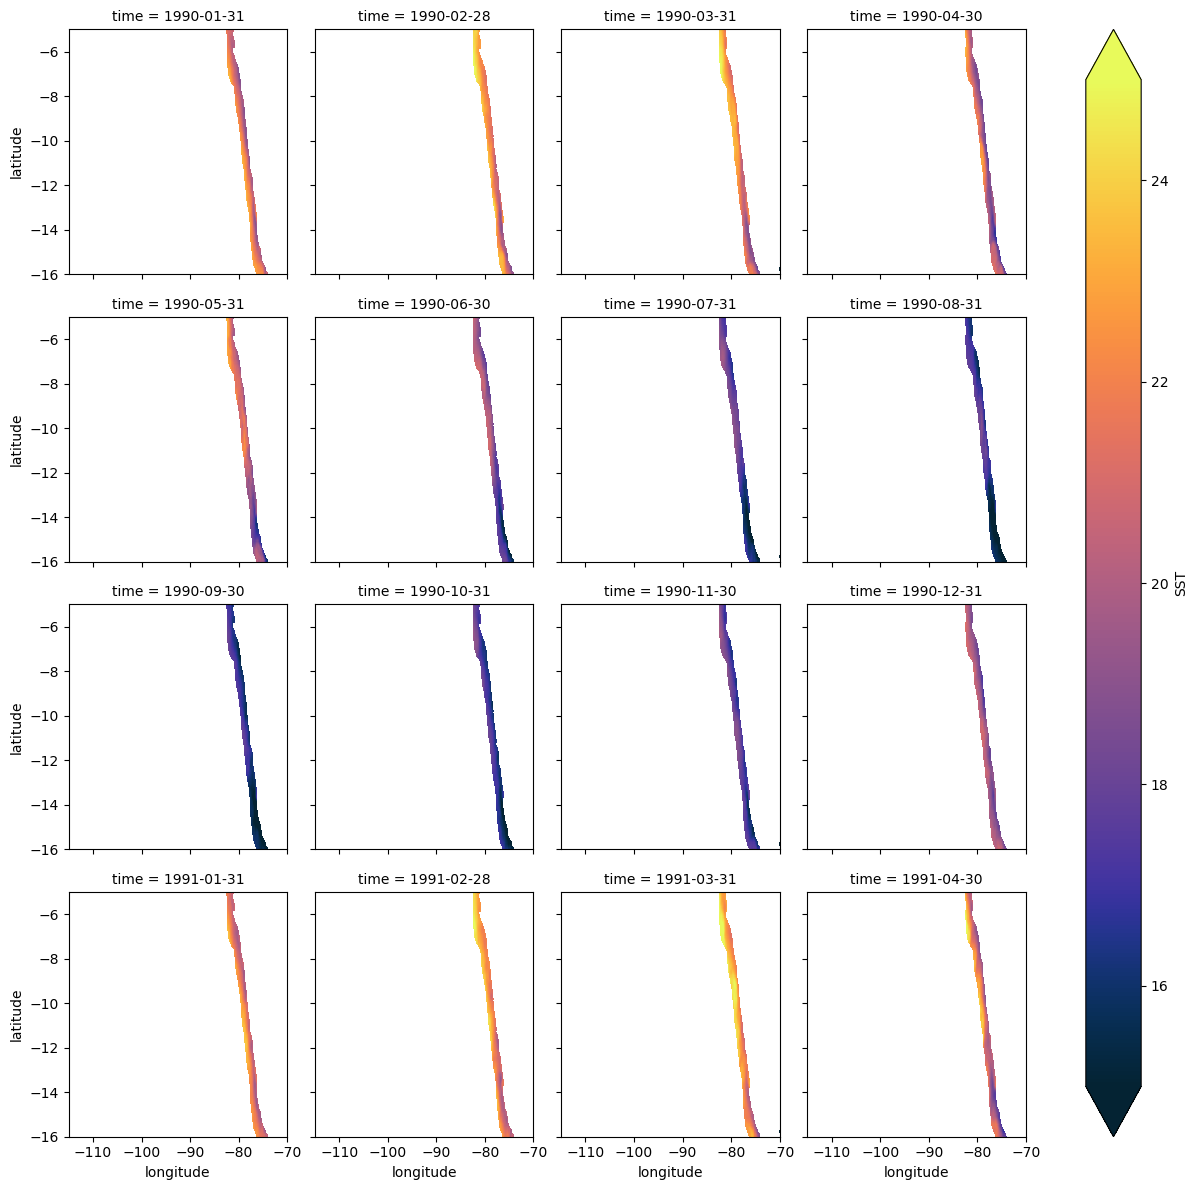

In [55]:
#INSHORE
SST_inshore.isel(time=slice(None,16)).plot(x="longitude", y="latitude", cmap=cm.thermal,
                                              col = 'time', col_wrap=4,
                                         vmin=15, vmax=25)

In [56]:
## Offshore 500km 
r5 = "../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/indices/BK500km.kml"
r6 = "../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/indices/BK600km.kml"

R5 = kml2struct(r5)
R6 = kml2struct(r6)

# Extract Lon and Lat from the first polygon
lonb5 = R5[0]["Lon"]
latb5 = R5[0]["Lat"]
lonb6 = R6[0]["Lon"]
latb6 = R6[0]["Lat"]

### cutting the 500km
polygon5 = Path(np.column_stack((lonb5, latb5)))
polygon6 = Path(np.column_stack((lonb6, latb6)))

# Check which points are inside the polygon
mask5 = polygon5.contains_points(lonlat_points).reshape(LON.shape)
mask6 = polygon6.contains_points(lonlat_points).reshape(LON.shape)

# Convert the mask to NaN for the outshore region
offshore_mask5 = np.where(mask5, 1, np.nan)
offshore_mask6 = np.where(mask6, 1, np.nan)

/tmp/ipykernel_2730771/4048778958.py:6: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar(label="Space Between Masks")


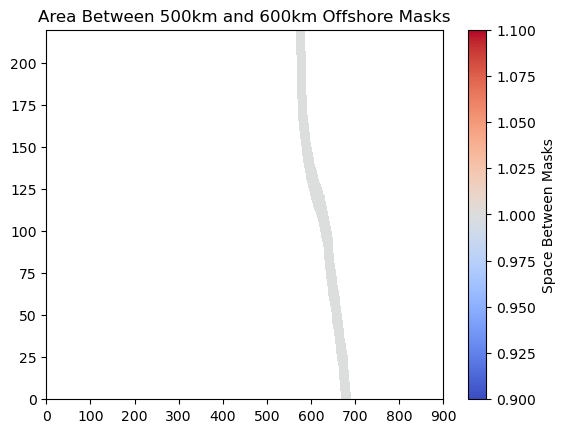

In [57]:
# Calculate the space between the two masks
space_between_masks = np.where((offshore_mask6 == 1) & (offshore_mask5 != 1), 1, np.nan)

# Plot the result
plt.pcolor(space_between_masks, cmap="coolwarm")
plt.colorbar(label="Space Between Masks")
plt.title("Area Between 500km and 600km Offshore Masks")
plt.show()

In [58]:
SST_offshore = SST['SST'] * space_between_masks
# SST_offshore = SST['SST'] * offshore_mask5
SST_offshore

<xarray.DataArray 'SST' (time: 252, latitude: 220, longitude: 900)> Size: 399MB
dask.array<mul, shape=(252, 220, 900), dtype=float64, chunksize=(1, 220, 900), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 880B -15.98 -15.93 -15.88 ... -5.075 -5.025
  * longitude  (longitude) float32 4kB -115.0 -114.9 -114.9 ... -70.07 -70.03
  * time       (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31
    month      (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

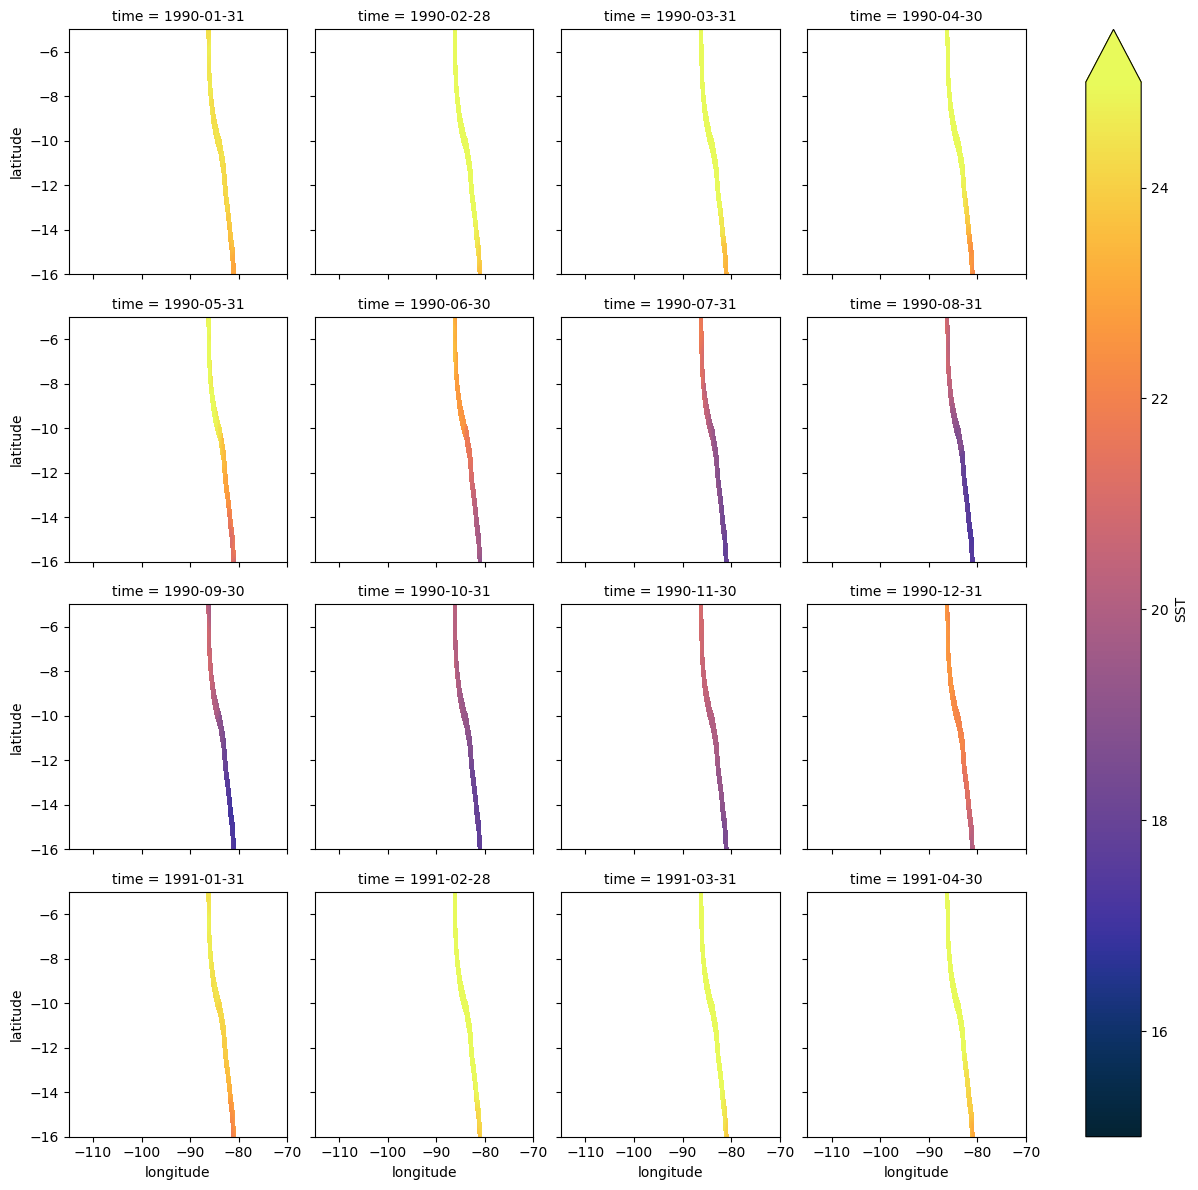

In [59]:
#OFFSHORE
SST_offshore.isel(time=slice(None,16)).plot(x="longitude", y="latitude", cmap=cm.thermal,
                                              col = 'time', col_wrap=4,
                                         vmin=15, vmax=25)

In [60]:
CUI_old = abs(SST_offshore.mean(dim='longitude') - SST_inshore.mean(dim='longitude'))
CUI_old

<xarray.DataArray 'SST' (time: 252, latitude: 220)> Size: 444kB
dask.array<abs, shape=(252, 220), dtype=float64, chunksize=(1, 220), chunktype=numpy.ndarray>
Coordinates:
  * latitude  (latitude) float32 880B -15.98 -15.93 -15.88 ... -5.075 -5.025
  * time      (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31
    month     (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

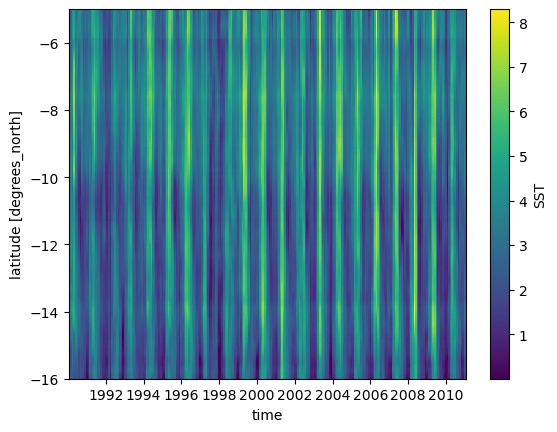

In [61]:
CUI_old.plot(x='time',y='latitude')

## CUI Max

In [62]:
## define SST inshore
SST_in=SST_inshore.to_dataset(name='sst_in')
SST_in = SST_in.rename({"latitude": "lat", "longitude": "lon"})
SST = SST.rename({'latitude':'lat','longitude':'lon'})
SST

<xarray.Dataset> Size: 798MB
Dimensions:  (lat: 220, lon: 900, time: 252)
Coordinates:
  * lat      (lat) float32 880B -15.98 -15.93 -15.88 ... -5.125 -5.075 -5.025
  * lon      (lon) float32 4kB -115.0 -114.9 -114.9 ... -70.12 -70.07 -70.03
  * time     (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31
    month    (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    SST      (time, lat, lon) float64 399MB dask.array<chunksize=(1, 220, 900), meta=np.ndarray>
    SSTa     (time, lat, lon) float64 399MB dask.array<chunksize=(1, 220, 900), meta=np.ndarray>

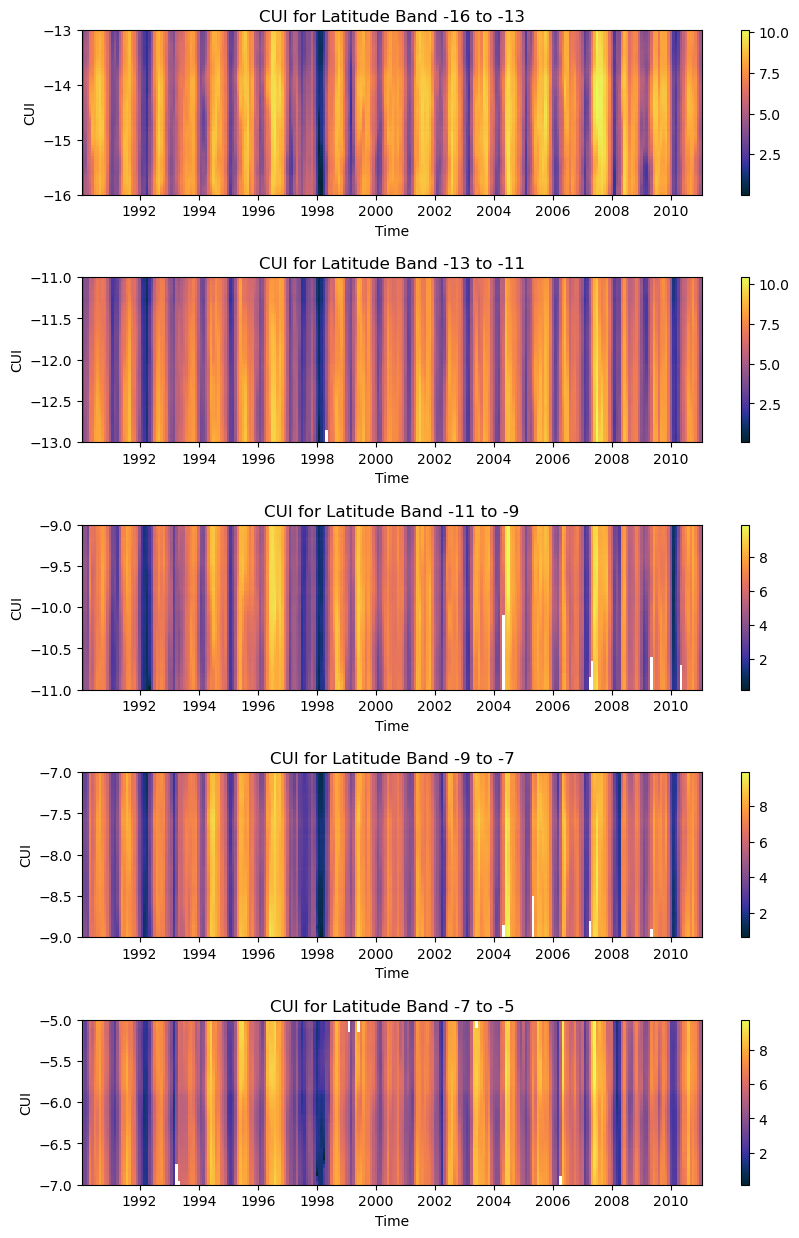

In [63]:
# Latitude bands in the Southern Hemisphere
latitude_bands = [(-16, -13), (-13, -11), (-11, -9), (-9, -7), (-7,-5)]

# Initialize figure
fig, axs = plt.subplots(len(latitude_bands), 1, figsize=(10, 15))
fig.subplots_adjust(hspace=0.5)

# Dictionary to store results
CUI_results = {}

# Loop through latitude bands
for i, (lat_min, lat_max) in enumerate(latitude_bands):
    # Step 1: Subset the data for the latitude band
    SST_lats_band = SST.SST.where(
        (SST['lat'] >= lat_min) & (SST['lat'] < lat_max), drop=True
    )

    reduced_mean=SST_in['sst_in'].where(
        (SST_in.lat >= lat_min) & (SST_in['lat'] < lat_max), drop=True).mean(dim=("lon",'lat')
                                                                     ,skipna=True)

    # Step 2: Compute absolute difference from reduced_mean
    abs_diff_band = abs(SST_lats_band - reduced_mean)
    
    # Step 3: Compute the 75th percentile (upper quartile)
    upper_quartile_band = abs_diff_band.quantile(0.75, dim=("lat", "lon"), skipna=True)
    
    # Step 4: Create the mask for values >= upper quartile
    upper_quartile_mask_band = abs_diff_band >= upper_quartile_band
    upper_quartile_mask_band = upper_quartile_mask_band.where(upper_quartile_mask_band != 0, drop=False)
    
    # Step 5: Apply the mask to SST_lats
    SST_off_band = upper_quartile_mask_band * SST_lats_band
    
    # Step 6: Compute reduced latitude mean for the latitude band
    reduced_lat_band = SST_in['sst_in'].where(
        (SST_in.lat >= lat_min) & (SST_in.lat < lat_max), drop=True
    ).mean(dim=("lon"), skipna=True)
    
    # Step 7: Calculate CUI_lat for the band
    CUI_lat_band = abs(SST_off_band.mean(dim="lon") - reduced_lat_band)
    CUI_results[(lat_min, lat_max)] = CUI_lat_band

    # Step 8: Plot
    CUI_lat_band.plot(ax=axs[i], x="time", y="lat", cmap=cm.thermal)
    axs[i].set_title(f"CUI for Latitude Band {lat_min} to {lat_max}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("CUI")

# Show the figure
plt.show()

In [64]:
CUI_results

{(-16,
  -13): <xarray.DataArray (time: 252, lat: 60)> Size: 121kB
 dask.array<abs, shape=(252, 60), dtype=float64, chunksize=(1, 60), chunktype=numpy.ndarray>
 Coordinates:
   * lat       (lat) float32 240B -15.98 -15.93 -15.88 ... -13.12 -13.07 -13.02
   * time      (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31
     month     (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
     quantile  float64 8B 0.75,
 (-13,
  -11): <xarray.DataArray (time: 252, lat: 40)> Size: 81kB
 dask.array<abs, shape=(252, 40), dtype=float64, chunksize=(1, 40), chunktype=numpy.ndarray>
 Coordinates:
   * lat       (lat) float32 160B -12.98 -12.93 -12.88 ... -11.12 -11.07 -11.02
   * time      (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31
     month     (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
     quantile  float64 8B 0.75,
 (-11,
  -9): <xarray.DataArray (time: 252, lat: 40)> Size: 81kB
 dask.array<abs, shape=(252, 40), dtype=float64,

In [65]:
CUI_16_13=CUI_results[(-16,-13)].mean(dim='lat',skipna=True).rolling(time=13,center=True).mean()
CUI_13_11=CUI_results[(-13,-11)].mean(dim='lat',skipna=True).rolling(time=13,center=True).mean()
CUI_11_9=CUI_results[(-11,-9)].mean(dim='lat',skipna=True).rolling(time=13,center=True).mean()
CUI_9_7=CUI_results[(-9,-7)].mean(dim='lat',skipna=True).rolling(time=13,center=True).mean()
CUI_7_5=CUI_results[(-7,-5)].mean(dim='lat',skipna=True).rolling(time=13,center=True).mean()


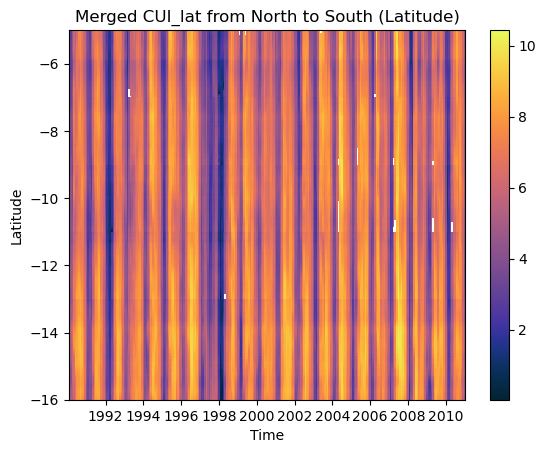

<xarray.DataArray (time: 252, lat: 220)> Size: 444kB
dask.array<getitem, shape=(252, 220), dtype=float64, chunksize=(1, 60), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float32 880B -15.98 -15.93 -15.88 ... -5.125 -5.075 -5.025
  * time      (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31
    month     (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
    quantile  float64 8B 0.75

In [66]:
CUI_lat_bands = []

# Merge all latitude bands from north (-7) to south (-16)
for lat_min, lat_max in latitude_bands:
    CUI_lat_band = CUI_results[(lat_min, lat_max)]
    CUI_lat_bands.append(CUI_lat_band)

# Concatenate all the latitude bands along the latitude dimension
CUI_merged = xr.concat(CUI_lat_bands, dim="lat")

# Sort by latitude to ensure correct ordering from north (-7) to south (-16)
CUI_merged = CUI_merged.sortby("lat")

# Plot the merged result
CUI_merged.plot(x="time", y="lat", cmap=cm.thermal)
plt.title("Merged CUI_lat from North to South (Latitude)")
plt.xlabel("Time")
plt.ylabel("Latitude")
plt.show()

# Display the merged dataset
CUI_merged

In [67]:
CUI_maxi = xr.Dataset(
    data_vars={
        'CUI_max':CUI_merged,
    },
)
CUI_maxi


<xarray.Dataset> Size: 448kB
Dimensions:   (lat: 220, time: 252)
Coordinates:
  * lat       (lat) float32 880B -15.98 -15.93 -15.88 ... -5.125 -5.075 -5.025
  * time      (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31
    month     (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
    quantile  float64 8B 0.75
Data variables:
    CUI_max   (time, lat) float64 444kB dask.array<chunksize=(1, 60), meta=np.ndarray>

Text(0, 0.5, 'Latitude')

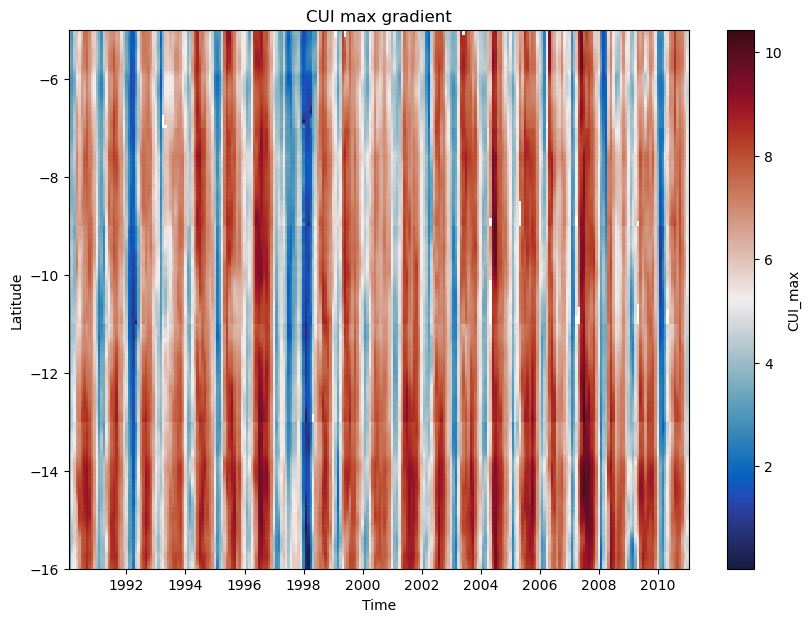

In [68]:
fig,axs = plt.subplots(1,1, figsize=(10,7))

CUI_maxi.CUI_max.plot(x="time", y="lat", cmap=cm.balance)
plt.title("CUI max gradient")
plt.xlabel("Time")
plt.ylabel("Latitude")

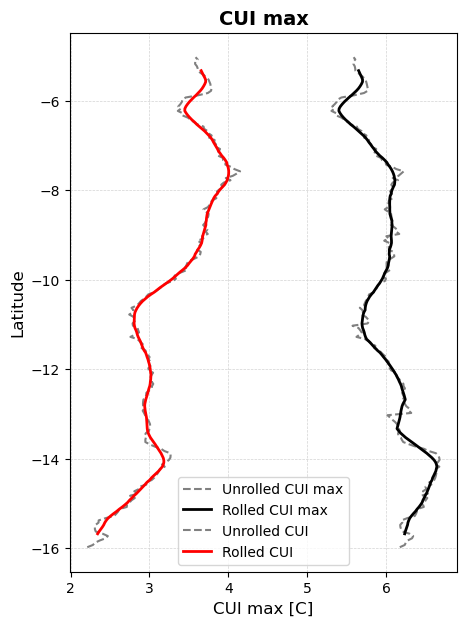

In [69]:
fig, axs = plt.subplots(1, 1, figsize=(5, 7))

# Plot the original (unrolled) CUI_max in grey
CUI_maxi.CUI_max.mean(dim='time').plot(
    y='lat', 
    ax=axs, 
    color='grey', 
    linestyle='--', 
    label='Unrolled CUI max'
)

# Plot the rolled CUI_max in thicker red
CUI_maxi.CUI_max.mean(dim='time').rolling(lat=13, center=True).mean().plot(
    y='lat', 
    ax=axs, 
    color='black', 
    linewidth=2, 
    label='Rolled CUI max'
)

#%--------CUI old ----------
CUI_old.mean(dim='time').plot(
    y='latitude', 
    ax=axs, 
    color='grey', 
    linestyle='--', 
    label='Unrolled CUI'
)

# Plot the rolled CUI_max in thicker red
CUI_old.mean(dim='time').rolling(latitude=13, center=True).mean().plot(
    y='latitude', 
    ax=axs, 
    color='red', 
    linewidth=2, 
    label='Rolled CUI'
)

# Add grid, title, and legend
axs.grid(color='lightgrey', linestyle='--', linewidth=0.5)
axs.set_title("CUI max", fontsize=14, fontweight='bold')
axs.legend(fontsize=10)
axs.set_xlabel("CUI max [C]", fontsize=12)
axs.set_ylabel("Latitude", fontsize=12)

# plt.savefig('../../NHCS/OSTIA/CUI_MAX_lat.png',format='png', 
#             dpi=300, transparent=True,bbox_inches='tight')
plt.show()
# Display the plot


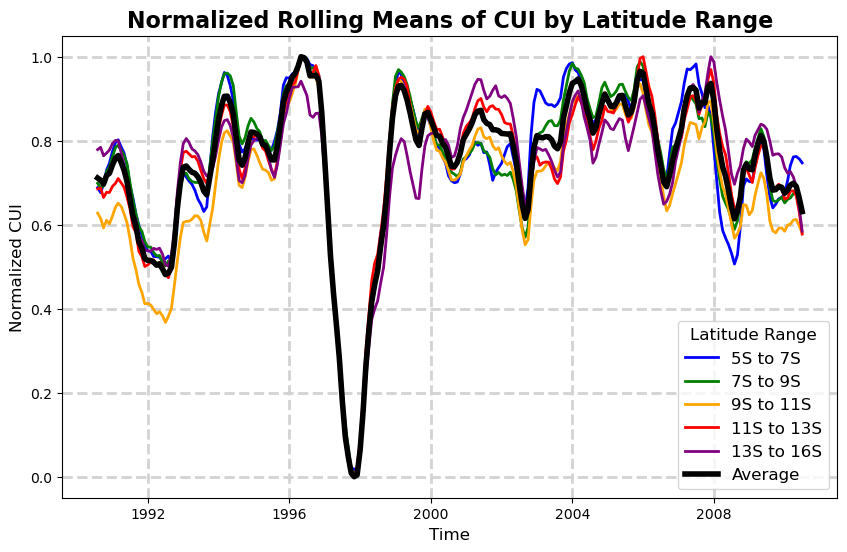

In [70]:
CUI_MAX=CUI_maxi.CUI_max.mean(dim='lat').rolling(time=13, center=True).mean()

def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

# Normalize each rolled mean
CUI_7_5_norm = normalize(CUI_7_5)
CUI_9_7_norm = normalize(CUI_9_7)
CUI_11_9_norm = normalize(CUI_11_9)
CUI_13_11_norm = normalize(CUI_13_11)
CUI_16_13_norm = normalize(CUI_16_13)
CUI_MAX_norm = normalize(CUI_MAX)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each normalized rolled mean
CUI_7_5_norm.plot(ax=ax, label="5S to 7S", color="blue", linewidth=2)
CUI_9_7_norm.plot(ax=ax, label="7S to 9S", color="green", linewidth=2)
CUI_11_9_norm.plot(ax=ax, label="9S to 11S", color="orange", linewidth=2)
CUI_13_11_norm.plot(ax=ax, label="11S to 13S", color="red", linewidth=2)
CUI_16_13_norm.plot(ax=ax, label="13S to 16S", color="purple", linewidth=2)
CUI_MAX_norm.plot(ax=ax, label="Average", color="black", linewidth=4)

# Add legend, grid, and labels
ax.legend(fontsize=12, loc="lower right", title="Latitude Range", title_fontsize=12)
ax.set_title("Normalized Rolling Means of CUI by Latitude Range", fontsize=16, fontweight="bold")
ax.set_xlabel("Time", fontsize=12)
ax.set_ylabel("Normalized CUI", fontsize=12)
ax.grid(color="lightgrey", linestyle="--", linewidth=2)

# plt.savefig('../../NHCS/OSTIA/CUI_lat_normal.png',format='png', 
#             dpi=300, transparent=True,bbox_inches='tight')

# Display the plot
plt.show()

## CUI Comparison

In [71]:
CUI_old

<xarray.DataArray 'SST' (time: 252, latitude: 220)> Size: 444kB
dask.array<abs, shape=(252, 220), dtype=float64, chunksize=(1, 220), chunktype=numpy.ndarray>
Coordinates:
  * latitude  (latitude) float32 880B -15.98 -15.93 -15.88 ... -5.075 -5.025
  * time      (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31
    month     (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

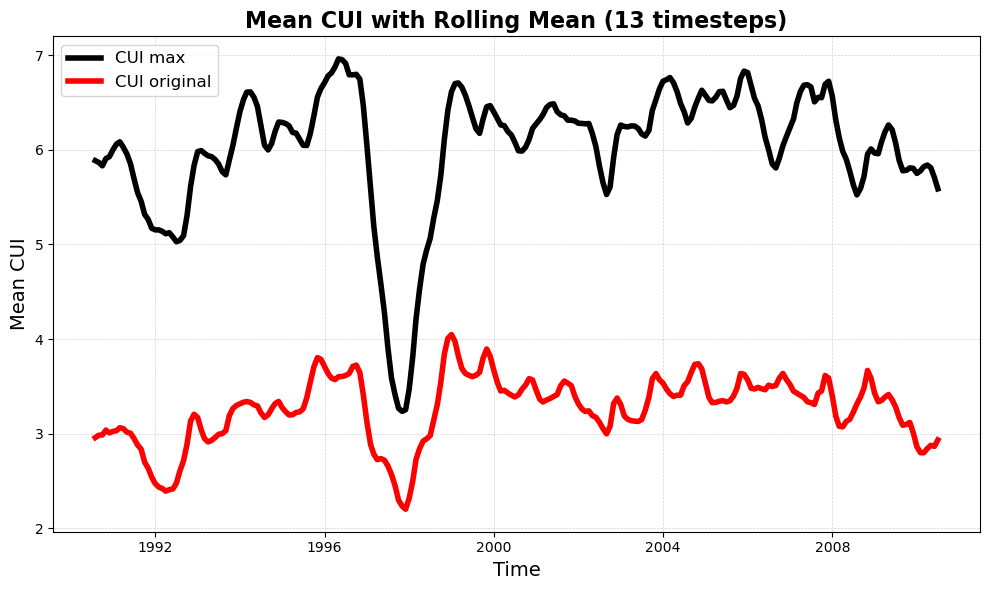

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

CUI_OLD=CUI_old.mean(dim='latitude').rolling(time=13, center=True).mean()
#df['Normalized_CUI'] = normalize(df['Rolling_Mean_CUI'])

# Plot the original and rolling mean CUI
plt.figure(figsize=(10, 6))
CUI_MAX.plot(color="black", linewidth=4, label='CUI max')
CUI_OLD.plot(color='Red', linewidth=4, label='CUI original')
plt.title("Mean CUI with Rolling Mean (13 timesteps)", fontsize=16, fontweight="bold")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Mean CUI", fontsize=14)
plt.grid(color="lightgrey", linestyle="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# plt.savefig('../../NHCS/OSTIA/CUI_ts_NoNorm.png',format='png', 
#             dpi=300, transparent=True,bbox_inches='tight')

plt.show()


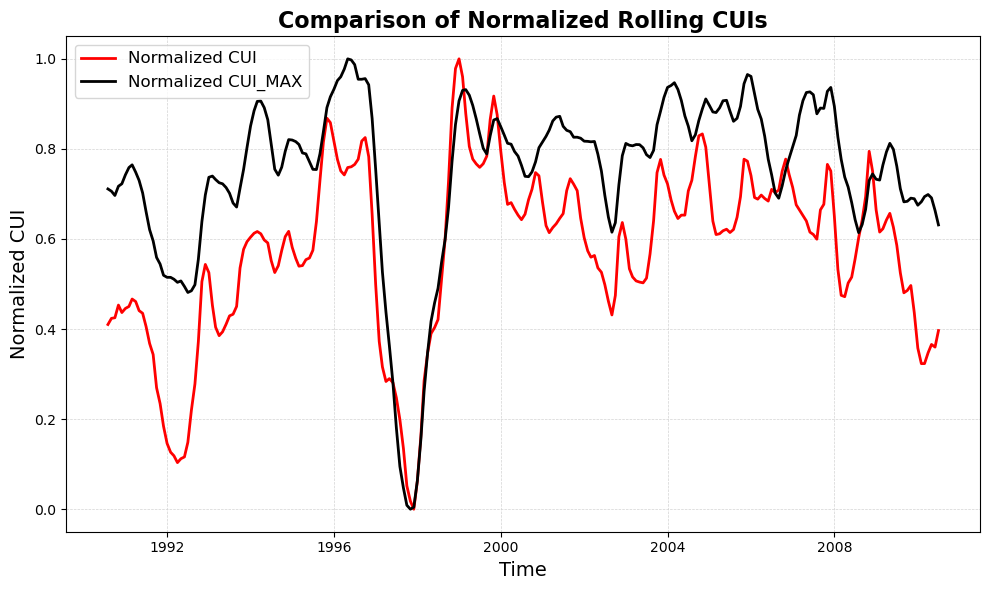

In [73]:
# Normalize the rolled Mean_CUI from MATLAB
# normalized_rolling_cui_old = (df['Rolling_Mean_CUI'] - df['Rolling_Mean_CUI'].min()) / (df['Rolling_Mean_CUI'].max() - df['Rolling_Mean_CUI'].min())
CUI_OLD_norm = normalize(CUI_OLD)
# Plot the normalized MATLAB Mean_CUI
plt.figure(figsize=(10, 6))

plt.plot(CUI_MAX.time, CUI_OLD_norm, label="Normalized CUI ", color="red", linewidth=2)

# Plot the normalized Python CUI_MAX
plt.plot(CUI_MAX.time, CUI_MAX_norm, label="Normalized CUI_MAX", color="black", linewidth=2)

# Formatting the plot
plt.title("Comparison of Normalized Rolling CUIs", fontsize=16, fontweight="bold")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Normalized CUI", fontsize=14)
plt.grid(color="lightgrey", linestyle="--", linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [74]:
CUI_old

<xarray.DataArray 'SST' (time: 252, latitude: 220)> Size: 444kB
dask.array<abs, shape=(252, 220), dtype=float64, chunksize=(1, 220), chunktype=numpy.ndarray>
Coordinates:
  * latitude  (latitude) float32 880B -15.98 -15.93 -15.88 ... -5.075 -5.025
  * time      (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31
    month     (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12

In [75]:
CUI_old = CUI_old.to_dataset(name='CUI_sat')
CUI_old = CUI_old.rename({'latitude':'lat'})

In [76]:
CUI_satellite = xr.Dataset(
    data_vars={
        'CUI_max':CUI_maxi.CUI_max,
        'CUI_old':CUI_old.CUI_sat}
)
CUI_satellite

<xarray.Dataset> Size: 892kB
Dimensions:   (lat: 220, time: 252)
Coordinates:
  * lat       (lat) float32 880B -15.98 -15.93 -15.88 ... -5.125 -5.075 -5.025
  * time      (time) datetime64[ns] 2kB 1990-01-31 1990-02-28 ... 2010-12-31
    month     (time) int64 2kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
    quantile  float64 8B 0.75
Data variables:
    CUI_max   (time, lat) float64 444kB dask.array<chunksize=(1, 60), meta=np.ndarray>
    CUI_old   (time, lat) float64 444kB dask.array<chunksize=(1, 220), meta=np.ndarray>

In [77]:
## to netcdf
CUI_satellite.to_netcdf("../../NHCS/OSTIA/CUI_satellite_ver2.nc")
